# Fraud Detection in Credit Card Transactions
## Modelling

### Team Members: Lewis, Patrick, Brian

This project aims to identify fraudulent credit card transactions. The dataset is a large dataset with 24,386,900 observations and 14 variables.

This workbook focuses on modelling. Resampling is done to create a smaller subset of the data for modelling (see separate workbook for exploratory analysis). DBSCAN is utilised to identify outliers, which are treated as potential anomalies for further investigations. A flagging system is also used to detect potential anomalies which are then combined with results from DBSCAN to form the final list of anomalies.

## Loading Libraries

In [40]:
## Dataset manipulation
import pandas as pd
import numpy as np

## Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Geopy
import geopy.distance
from geopy.geocoders import Nominatim

## Distribution
from scipy.stats import poisson

## Preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

## Clustering
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score
from sklearn.svm import OneClassSVM
from sklearn.metrics import davies_bouldin_score

## Setting Display Styles

In [41]:
plt.style.use('dark_background')

In [42]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

## Writing Functions

### Data Cleaning and Feature Engineering

In [43]:
def credit_cleanup(df):
    
    """ 
    This function contains nearly all the feature engineering and data cleaning methods applied to the data
    --------------------------------------------------------------------------------------------------------
    df: dataframe
    """
    
    ## Cleaning Amount and converting to flaot
    df['Amount'] = df['Amount'].apply(lambda x: float(x[1:]))
    print('Cleaning Amount Column - Done')
    
    ## Cleaning Errors 
    df['Errors?'].fillna('None',inplace=True)
    print('Cleaning Error Column - Done')
    
    ## Merging month and year
    
    df['Y/M'] = df['Year'] + (df['Month']/12) + (df['Day']/365)
    print('Merging month year and day - Done')
    
    
    ## MCC mapping
    mcc_dict = dict([(i,'Contracted') for i in range(1500, 2999)] 
                + [(i,'Airlines') for i in range(3000, 3299)]
                + [(i, 'Car Rental') for i in range(3300, 3499)]
                + [(i, 'Lodging') for i in range(3500, 3999)]
                + [(i, 'Transportation') for i in range(4000, 4799)]
                + [(i, 'Utility') for i in range(4800, 4999)]
                + [(i, 'Retail') for i in range(5000, 5599)]
                + [(i, 'Clothing') for i in range(5600, 5699)]
                + [(i, 'Miscellaneous') for i in range(5700, 7299)]
                + [(i, 'Business') for i in range(7300, 7999)]
                + [(i, 'Professional') for i in range(8000, 8999)]
                + [(i, 'Government') for i in range(9000, 9999)])
                    
                    
    df['Category'] = df['MCC'].map(mcc_dict)
    print('Category (MCC) mapping - Done')
    
    ## Creating a new colum for time and creating a new column comparing to a user's average time
    
    df['TimeDecimal'] = df['Time'].apply(lambda x: int(x[:2])+(int(x[-2:])/60))
    time_medians = df.groupby(['User'])['TimeDecimal'].median().reset_index()
    time_medians.columns = ['User','User_median_time']
    df = pd.merge(df, time_medians, how = 'left', left_on = ['User'], right_on = 'User')
    df['Time_differential'] = abs(df['User_median_time']-df['TimeDecimal']) 
    print('User time differential - Done')
    
    ## Creating a column for error count
    
    df['Error_count'] = df['Errors?'].apply(lambda x: len(x.split(','))-1 )
    print('Error count - Done')
    
    ## Creating columns for median user amount and how much a transaction differs from their norm
    
    medians = df.groupby(['User'])['Amount'].median().reset_index()
    medians.columns = ['User', 'User_median_Amount']
    df = pd.merge(df, medians, how = 'left',left_on = ['User'],right_on = ['User'])
    df['Med_price_differential'] = abs(df['Amount']-df['User_median_Amount'])
    print('User Price Differential - Done')
    
    ## Adding column for user purchases for each category
    
    lol = df.groupby(['User','Category']).agg(lambda x: x.count())['Card'].reset_index()
    lol.columns = ['User', 'Category', 'CountCategory']
    df = pd.merge(df, lol, how = 'left', left_on = ['User','Category'], right_on = ['User','Category'])
    print('Purchases per category - Done')
    
    ## Calculating liklihood of a transaction occuring for that person
    
    x = df['User'].value_counts().reset_index()
    x.columns = ['User','TotalTransactionCount']
    df = pd.merge(df, x, on = 'User')
    del x
    df['CategoryTransactionProbability'] = df['CountCategory']/df['TotalTransactionCount']
    print('Category transaction probability - Done')
    
    ## Calculating the probability that x transactions will occur for the customer in the same month
    
    i = 0
    time_diff = []

    for i in sorted(list(df['User'].value_counts().index)):
        time_diff.append(df[df['User'] == i]['Y/M'].max()-df[df['User'] == i]['Y/M'].min())
        
    time_diff = pd.DataFrame({'User':sorted(list(df['User'].value_counts().index)), 'UserDuration':time_diff})
    df = pd.merge(df, time_diff, on = 'User')
    df['UserDuration'] = df['UserDuration'].replace(0.0, 0.08333)
    
    ## Calculating transaction per month
    
    df['TransactionsPerMonth'] = (df['TotalTransactionCount']/df['UserDuration'])/12
    
    print('Transaction per month calculations - Done')
    
    ## Calculating transaction count in same month
    
    banter = df.groupby(['User','Year','Month']).agg(lambda x: x.count())['Card'].reset_index()
    banter.columns = ['User', 'Year', 'Month', 'ThisMonthTransactionCount']
    df = pd.merge(df, banter, how = 'left', left_on = ['User', 'Year', 'Month'], right_on = ['User', 'Year', 'Month'])
    
    print('User current transaction count in same month - Done')
    
    ## Monthly transaction difference
    
    df['MonthlyTransactionCountDifference'] = abs(df['ThisMonthTransactionCount']-df['TransactionsPerMonth'])
    print('Transaction Count Difference - Done')
    
    ## Probability that this many transactions could have occured in the same month (Poisson distribution)
    
    df['CombinedTransactionCountProbability'] = poisson.pmf(df['ThisMonthTransactionCount'], df['TransactionsPerMonth'])
    print('N transaction in the same month probability - Done')
    
    df['Merchant State'] = df['Merchant State'].fillna('ONLINE')
    
    ## Hour columns
    
    df['Hour'] = df['Time'].apply(lambda x: int(x[:2]))
    df['Hour'] = df['Hour'].astype('int64')
    
    
    return df

In [44]:
def zip_grouping(x):
    if float(x)<10000:
        return '0-10k'
    else:
        pass
    if float(x)<20000:
        return '10-20k'
    else:
        pass
    if float(x)<30000:
        return '20-30k'
    else:
        pass
    if float(x)<40000:
        return '30-40k'
    else:
        pass
    if float(x)<50000:
        return '40-50k'
    else:
        pass
    if float(x)<60000:
        return '50-60k'
    else:
        pass
    if float(x)<70000:
        return '60-70k'
    else:
        pass
    if float(x)<80000:
        return '70-80k'
    else:
        pass
    if float(x)<90000:
        return '80-90k'
    else:
        pass
    if float(x)<100000:
        return '90-100k'
    else:
        pass
    if float(x) == 1e6:
        return x
    else:
        pass

In [45]:
### ONE hot encode remaining columns

In [46]:
# df = pd.get_dummies(df,columns=['ZipCat','Category','Merchant State','Use Chip'])
# df = pd.get_dummies(df,columns=['Use Chip'])

In [48]:
users = [ 371, 1036, 1298, 1471, 1688, 1092, 1565,  818,  479, 1503,  479,
        400,  353,  190, 1221, 1544, 1764, 1839,   30, 1462,  830,  601,
       1715, 1719, 1235,  577, 1422,  893,  990,  478,  433,  957, 1564,
       1452,  759,  352,  366,  997,  235, 1836, 1120,  914,  322,  463,
        123, 1191, 1867,  992, 1809, 1714, 1892, 1681,  230, 1932, 1213,
        500, 1204,  406,   18, 1602,  134,  361, 1971,  634, 1279,  814,
        648, 1612, 1358, 1597,  372, 1308, 1104, 1689, 1747, 1338, 1619,
       1279,  753,  768,  632, 1872, 1854,  964, 1955, 1122, 1532,  845,
       1273, 1331,  265, 1420, 1415,  441,   30,  826,  458,  378, 1773,
       1649,  668, 1059, 1577,  587, 1634, 1024,  156, 1313, 1283, 1483,
        515, 1307, 1000, 1100, 1273, 1396, 1653, 1530,  888, 1675, 1018,
       1359, 1097,  715, 1988, 1005,  486, 1631,  677,  933,  720, 1848,
        296, 1943,  656, 1901,  114, 1482, 1972,  345,  518, 1688, 1671,
        294,  894, 1813,  588,   57,  602,  745, 1735,   42,  684, 1857,
        731, 1817, 1721,  601, 1446,  105, 1533, 1083,  572, 1521, 1925,
        354, 1515,  452,  780,  705, 1636,  682, 1970, 1937, 1732, 1835,
       1212, 1720,   21, 1422, 1871, 1520, 1370, 1872, 1762, 1401, 1215,
        563, 1007,  144,  500, 1057, 1540, 1435, 1080, 1801,  133,  547,
        518,   92, 1651, 1076,  160, 1487,  622, 1224,  605,   84, 1316,
       1594, 1701,  818,  445,  962, 1201,  564,  172,  477, 1312,  792,
       1144,  952, 1540, 1351,  207, 1329,  425,  323,   15,  784,  247,
       1013, 1268,  462, 1561,   82,  719,   18, 1570,  646, 1766,  997,
       1910,  666, 1416,  785, 1959, 1620, 1288, 1311,  563, 1829, 1381,
       1813, 1399,  497,  314,   36,   69,  743, 1253, 1072,  265, 1453,
       1018, 1635, 1826, 1853,   14, 1545, 1696,  168, 1144, 1234, 1215,
       1188, 1026, 1600, 1877,  726, 1858, 1684, 1032, 1797,   26,  755,
        947, 1776,  767,  845, 1143, 1028, 1656,  597, 1989, 1966, 1131,
       1176, 1477, 1361,  499,  714,  662,  536,  886,  443,  435, 1252,
        892,  414,  662,  758, 1795,  619, 1048,   34, 1698,  863,  955,
        107,  252, 1836, 1134,  819, 1558,  925, 1104,  841, 1546,  277,
        106,  671,  627,  429,  222, 1541,  530,  562,  193,  926,  606,
       1480, 1592, 1715,  567,  608, 1897,  481, 1002,  914,  963, 1412,
        461,  497, 1665, 1654,  649, 1975,  492,  773, 1750,  669,  615,
       1926, 1605,  851,   89,  259, 1463, 1183, 1362, 1720, 1454,  921,
       1808, 1920, 1403, 1162, 1373, 1193,  753,  255, 1640,  668,  703,
        664, 1999,  826, 1107,  248,  175, 1858,  520,  360,  733, 1568,
        501,  803, 1248, 1293,  124, 1433,  700, 1306,  378, 1327,  379,
        537,  552, 1303, 1291,  564,  109, 1948, 1522, 1938,  886,   92,
       1748, 1842, 1336, 1091,  265,  559,   91, 1907, 1784,  774,  545,
       1697,  664,  404,   90, 1771, 1033,  336, 1365,  528,  774, 1144,
       1897,  142,  322, 1706,  453,  376,  367, 1782,  185, 1391, 1031,
        686,  284,  967,  226,  531,  415, 1909,  751, 1502, 1371,  146,
       1270, 1776, 1478, 1898, 1161,  702, 1680, 1132,  642,  164, 1105,
       1617,  240,  835,  947,    9, 1242,  954,    3,  244, 1686,  420,
        205, 1058, 1935, 1555,  486,  322, 1383,  245, 1536, 1399,    6,
        518,  657, 1355, 1550,  848]

In [49]:
users[2]

1298

In [50]:
cutoff = 2660.75*(data['User'].nunique()/2000)
cutoff

599.999125

In [51]:
data = pd.read_csv('lpb_sampled_transactions.csv')

In [52]:
data.head()

,Unnamed: 0,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?
0,0,372,0,2005,4,1,08:11,$16.82,Swipe Transaction,-1288082279022882052,Pendleton,SC,29670.0,5499,NaN
1,1,372,0,2005,4,1,08:13,$-60.00,Swipe Transaction,-1288082279022882052,Pendleton,SC,29670.0,5499,NaN
2,2,372,0,2005,4,1,08:22,$60.00,Swipe Transaction,-1288082279022882052,Pendleton,SC,29670.0,5499,NaN
3,3,372,0,2005,4,1,11:26,$10.79,Swipe Transaction,-5475680618560174533,Piedmont,SC,29673.0,5942,NaN
4,4,372,0,2005,4,1,12:29,$40.74,Swipe Transaction,5197669410074974271,Ninety Six,SC,29666.0,7538,NaN


In [53]:
data['User'].nunique()

451

In [54]:
len(data)

5732218

In [55]:
data = credit_cleanup(data)

Cleaning Amount Column - Done
Cleaning Error Column - Done
Merging month year and day - Done
Category (MCC) mapping - Done
User time differential - Done
Error count - Done
User Price Differential - Done
Purchases per category - Done
Category transaction probability - Done
Transaction per month calculations - Done
User current transaction count in same month - Done
Transaction Count Difference - Done
N transaction in the same month probability - Done


In [56]:
data['Zip'] = data['Zip'].fillna(1e6)
data['ZipCat'] = data['Zip'].apply(zip_grouping)
data = pd.get_dummies(data,columns = ['ZipCat', 'Category', 'Merchant State', 'Use Chip', 'Card'])

In [57]:
data.head()

,Unnamed: 0,User,Year,Month,Day,Time,Amount,Merchant Name,Merchant City,Zip,MCC,Errors?,Y/M,TimeDecimal,User_median_time,Time_differential,Error_count,User_median_Amount,Med_price_differential,CountCategory,TotalTransactionCount,CategoryTransactionProbability,UserDuration,TransactionsPerMonth,ThisMonthTransactionCount,MonthlyTransactionCountDifference,CombinedTransactionCountProbability,Hour,ZipCat_1000000.0,ZipCat_0-10k,ZipCat_10-20k,ZipCat_20-30k,ZipCat_30-40k,ZipCat_40-50k,ZipCat_50-60k,ZipCat_60-70k,ZipCat_70-80k,ZipCat_80-90k,ZipCat_90-100k,Category_Airlines,Category_Business,Category_Car Rental,Category_Clothing,Category_Contracted,Category_Government,Category_Lodging,Category_Miscellaneous,Category_Professional,Category_Retail,Category_Transportation,Category_Utility,Merchant State_AA,Merchant State_AK,Merchant State_AL,Merchant State_AR,Merchant State_AZ,Merchant State_Algeria,Merchant State_Antigua and Barbuda,Merchant State_Argentina,Merchant State_Aruba,Merchant State_Australia,Merchant State_Austria,Merchant State_Bahrain,Merchant State_Bangladesh,Merchant State_Barbados,Merchant State_Belarus,Merchant State_Belgium,Merchant State_Benin,Merchant State_Bosnia and Herzegovina,Merchant State_Botswana,Merchant State_Brazil,Merchant State_CA,Merchant State_CO,Merchant State_CT,Merchant State_Cambodia,Merchant State_Cameroon,Merchant State_Canada,Merchant State_Central African Republic,Merchant State_Chile,Merchant State_China,Merchant State_Colombia,Merchant State_Costa Rica,Merchant State_Croatia,Merchant State_Cyprus,Merchant State_Czech Republic,Merchant State_DC,Merchant State_DE,Merchant State_Denmark,Merchant State_Djibouti,Merchant State_Dominican Republic,Merchant State_Ecuador,Merchant State_Egypt,Merchant State_Eritrea,Merchant State_Estonia,Merchant State_FL,Merchant State_Fiji,Merchant State_Finland,Merchant State_France,Merchant State_GA,Merchant State_Germany,Merchant State_Greece,Merchant State_Guatemala,Merchant State_Guyana,Merchant State_HI,Merchant State_Haiti,Merchant State_Hong Kong,Merchant State_Hungary,Merchant State_IA,Merchant State_ID,Merchant State_IL,Merchant State_IN,Merchant State_Iceland,Merchant State_India,Merchant State_Indonesia,Merchant State_Ireland,Merchant State_Israel,Merchant State_Italy,Merchant State_Jamaica,Merchant State_Japan,Merchant State_Jordan,Merchant State_KS,Merchant State_KY,Merchant State_Kenya,Merchant State_LA,Merchant State_Latvia,Merchant State_Lebanon,Merchant State_Liechtenstein,Merchant State_Lithuania,Merchant State_Luxembourg,Merchant State_MA,Merchant State_MD,Merchant State_ME,Merchant State_MI,Merchant State_MN,Merchant State_MO,Merchant State_MS,Merchant State_MT,Merchant State_Macedonia,Merchant State_Malawi,Merchant State_Malaysia,Merchant State_Maldives,Merchant State_Mali,Merchant State_Malta,Merchant State_Mexico,Merchant State_Monaco,Merchant State_Mongolia,Merchant State_Morocco,Merchant State_Myanmar (Burma),Merchant State_NC,Merchant State_ND,Merchant State_NE,Merchant State_NH,Merchant State_NJ,Merchant State_NM,Merchant State_NV,Merchant State_NY,Merchant State_Netherlands,Merchant State_New Zealand,Merchant State_Nicaragua,Merchant State_Niger,Merchant State_Nigeria,Merchant State_Norway,Merchant State_OH,Merchant State_OK,Merchant State_ONLINE,Merchant State_OR,Merchant State_PA,Merchant State_Pakistan,Merchant State_Peru,Merchant State_Philippines,Merchant State_Poland,Merchant State_Portugal,Merchant State_RI,Merchant State_Russia,Merchant State_SC,Merchant State_SD,Merchant State_Sao Tome and Principe,Merchant State_Saudi Arabia,Merchant State_Serbia,Merchant State_Singapore,Merchant State_Slovakia,Merchant State_Slovenia,Merchant State_Somalia,Merchant State_South Africa,Merchant State_South Korea,Merchant State_Spain,Merchant State_Sri Lanka,Merchant State_Sweden,Merchant State_Switzerland,Merchant State_TN,Merchant State_TX,Merchant State_Taiwan,Merchant State_Thailand,Merchant State_The Bahamas,Merchant State_Tunisia,Merchant State_

In [58]:
list(data.columns)

['Unnamed: 0',
 'User',
 'Year',
 'Month',
 'Day',
 'Time',
 'Amount',
 'Merchant Name',
 'Merchant City',
 'Zip',
 'MCC',
 'Errors?',
 'Y/M',
 'TimeDecimal',
 'User_median_time',
 'Time_differential',
 'Error_count',
 'User_median_Amount',
 'Med_price_differential',
 'CountCategory',
 'TotalTransactionCount',
 'CategoryTransactionProbability',
 'UserDuration',
 'TransactionsPerMonth',
 'ThisMonthTransactionCount',
 'MonthlyTransactionCountDifference',
 'CombinedTransactionCountProbability',
 'Hour',
 'ZipCat_1000000.0',
 'ZipCat_0-10k',
 'ZipCat_10-20k',
 'ZipCat_20-30k',
 'ZipCat_30-40k',
 'ZipCat_40-50k',
 'ZipCat_50-60k',
 'ZipCat_60-70k',
 'ZipCat_70-80k',
 'ZipCat_80-90k',
 'ZipCat_90-100k',
 'Category_Airlines',
 'Category_Business',
 'Category_Car Rental',
 'Category_Clothing',
 'Category_Contracted',
 'Category_Government',
 'Category_Lodging',
 'Category_Miscellaneous',
 'Category_Professional',
 'Category_Retail',
 'Category_Transportation',
 'Category_Utility',
 'Merchant S

In [60]:
columns = ['Year', 'Month', 'Med_price_differential',
           'TimeDecimal','Error_count',
           'Med_price_differential','CategoryTransactionProbability',
           'MonthlyTransactionCountDifference','CombinedTransactionCountProbability',
           'Category_Airlines',
           'Category_Business',
           'Category_Car Rental',
           'Category_Clothing',
           'Category_Contracted',
           'Category_Government',
           'Category_Lodging',
           'Category_Miscellaneous',
           'Category_Professional',
           'Category_Retail',
           'Category_Transportation',
           'Category_Utility',
           'Use Chip_Chip Transaction',
           'Use Chip_Online Transaction',
           'Use Chip_Swipe Transaction']
columns_for_graph = ['Med_price_differential', 'TimeDecimal']           

In [61]:
len(columns)

24

In [64]:
df_total = pd.DataFrame()
for user_num in users:
    df_user = data[data['User'] == user_num + 1]
    print(len(df_user))
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_user[columns])
    dbc = DBSCAN(eps = 0.035, metric = 'cosine', min_samples=24)
    dbc.fit_predict(X_scaled)
    df_user['labels'] = dbc.labels_
    df_total = pd.concat([df_total, df_user], ignore_index = True)
    del df_user
    print(len(df_total))
    print('User {} finished'.format(user_num + 1))


12563


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


12563
User 372 finished
6266


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


18829
User 1037 finished
13056


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


31885
User 1299 finished
19082


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


50967
User 1472 finished
24430


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


75397
User 1689 finished
5276


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


80673
User 1093 finished
8124


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


88797
User 1566 finished
43132


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


131929
User 819 finished
57210


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


189139
User 480 finished
10171
199310
User 1504 finished


H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [21]:
dict_map = dict([(i,0) for i in range(0, 10000)])
df_total['labels'] = df_total['labels'].map(dict_map)
df_total['labels'] = df_total['labels'].replace(np.nan,1)

In [22]:
df_total['labels'].value_counts()

 10    3044
 2     2287
 11    1802
 0     1470
 1     1416
 12    1145
 3      588
-1      429
 4      198
 8      122
 5      119
 7       76
 16      72
 13      65
 14      62
 6       42
 9       35
 17      33
 15      26
 18      25
Name: labels, dtype: int64

In [23]:
df_total['User'].value_counts()

1299    13056
Name: User, dtype: int64

In [24]:
df_total.head()

,Unnamed: 0,User,Year,Month,Day,Time,Amount,Merchant Name,Merchant City,Zip,MCC,Errors?,Y/M,TimeDecimal,User_median_time,Time_differential,Error_count,User_median_Amount,Med_price_differential,CountCategory,TotalTransactionCount,CategoryTransactionProbability,UserDuration,TransactionsPerMonth,ThisMonthTransactionCount,MonthlyTransactionCountDifference,CombinedTransactionCountProbability,Hour,ZipCat_1000000.0,ZipCat_0-10k,ZipCat_10-20k,ZipCat_20-30k,ZipCat_30-40k,ZipCat_40-50k,ZipCat_50-60k,ZipCat_60-70k,ZipCat_70-80k,ZipCat_80-90k,ZipCat_90-100k,Category_Airlines,Category_Business,Category_Car Rental,Category_Clothing,Category_Contracted,Category_Government,Category_Lodging,Category_Miscellaneous,Category_Professional,Category_Retail,Category_Transportation,Category_Utility,Merchant State_AA,Merchant State_AK,Merchant State_AL,Merchant State_AR,Merchant State_AZ,Merchant State_Algeria,Merchant State_Antigua and Barbuda,Merchant State_Argentina,Merchant State_Aruba,Merchant State_Australia,Merchant State_Austria,Merchant State_Bahrain,Merchant State_Bangladesh,Merchant State_Barbados,Merchant State_Belarus,Merchant State_Belgium,Merchant State_Benin,Merchant State_Bosnia and Herzegovina,Merchant State_Botswana,Merchant State_Brazil,Merchant State_CA,Merchant State_CO,Merchant State_CT,Merchant State_Cambodia,Merchant State_Cameroon,Merchant State_Canada,Merchant State_Central African Republic,Merchant State_Chile,Merchant State_China,Merchant State_Colombia,Merchant State_Costa Rica,Merchant State_Croatia,Merchant State_Cyprus,Merchant State_Czech Republic,Merchant State_DC,Merchant State_DE,Merchant State_Denmark,Merchant State_Djibouti,Merchant State_Dominican Republic,Merchant State_Ecuador,Merchant State_Egypt,Merchant State_Eritrea,Merchant State_Estonia,Merchant State_FL,Merchant State_Fiji,Merchant State_Finland,Merchant State_France,Merchant State_GA,Merchant State_Germany,Merchant State_Greece,Merchant State_Guatemala,Merchant State_Guyana,Merchant State_HI,Merchant State_Haiti,Merchant State_Hong Kong,Merchant State_Hungary,Merchant State_IA,Merchant State_ID,Merchant State_IL,Merchant State_IN,Merchant State_Iceland,Merchant State_India,Merchant State_Indonesia,Merchant State_Ireland,Merchant State_Israel,Merchant State_Italy,Merchant State_Jamaica,Merchant State_Japan,Merchant State_Jordan,Merchant State_KS,Merchant State_KY,Merchant State_Kenya,Merchant State_LA,Merchant State_Latvia,Merchant State_Lebanon,Merchant State_Liechtenstein,Merchant State_Lithuania,Merchant State_Luxembourg,Merchant State_MA,Merchant State_MD,Merchant State_ME,Merchant State_MI,Merchant State_MN,Merchant State_MO,Merchant State_MS,Merchant State_MT,Merchant State_Macedonia,Merchant State_Malawi,Merchant State_Malaysia,Merchant State_Maldives,Merchant State_Mali,Merchant State_Malta,Merchant State_Mexico,Merchant State_Monaco,Merchant State_Mongolia,Merchant State_Morocco,Merchant State_Myanmar (Burma),Merchant State_NC,Merchant State_ND,Merchant State_NE,Merchant State_NH,Merchant State_NJ,Merchant State_NM,Merchant State_NV,Merchant State_NY,Merchant State_Netherlands,Merchant State_New Zealand,Merchant State_Nicaragua,Merchant State_Niger,Merchant State_Nigeria,Merchant State_Norway,Merchant State_OH,Merchant State_OK,Merchant State_ONLINE,Merchant State_OR,Merchant State_PA,Merchant State_Pakistan,Merchant State_Peru,Merchant State_Philippines,Merchant State_Poland,Merchant State_Portugal,Merchant State_RI,Merchant State_Russia,Merchant State_SC,Merchant State_SD,Merchant State_Sao Tome and Principe,Merchant State_Saudi Arabia,Merchant State_Serbia,Merchant State_Singapore,Merchant State_Slovakia,Merchant State_Slovenia,Merchant State_Somalia,Merchant State_South Africa,Merchant State_South Korea,Merchant State_Spain,Merchant State_Sri Lanka,Merchant State_Sweden,Merchant State_Switzerland,Merchant State_TN,Merchant State_TX,Merchant State_Taiwan,Merchant State_Thailand,Merchant State_The Bahamas,Merchant State_Tunisia,Merchant State_

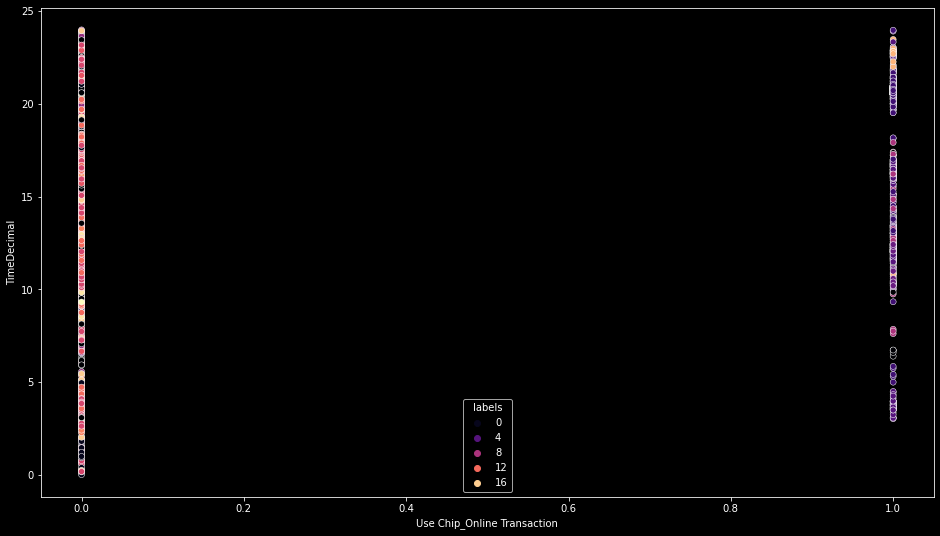

In [25]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_total,y='TimeDecimal',x='Use Chip_Online Transaction',hue='labels',palette='magma')
plt.savefig('DBSCAN_user.png',dpi=500)

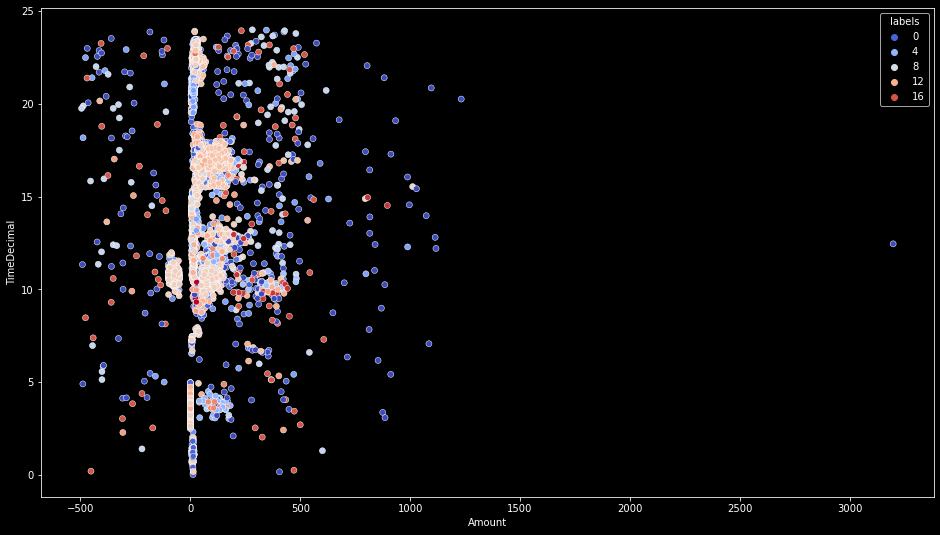

In [26]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_total,y='TimeDecimal',x='Amount',hue='labels',palette='coolwarm')# 'magma')
plt.savefig('DBSCAN2_user.png',dpi=500)